# Imports

In [749]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report 
from sklearn.metrics import plot_roc_curve
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
import time
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Ridge

## Data Import and Cleaning 

### Import Historic Stats

In [750]:
current_week = int(input("Input Current NFL Week"))
print(current_week)

Input Current NFL Week3
3


In [751]:
years = [2017, 2018, 2019, 2020, 2021]

In [752]:
stats_list = []
for year in years:
    if year != 2021:
        for i in range(1,18):
            name = 'Data/Historic_Stats/'+ str(year) + '_' + str(i) + '.csv'
            stats_list.append(name)
    else:
        for i in range(1, current_week):
            name = 'Data/Historic_Stats/'+ str(year) + '_' + str(i) + '.csv'
            stats_list.append(name)

In [753]:
stats_list[0][-10:-6]

'2017'

In [754]:
len('Data/Historic_Stats/2017_10.csv')

31

In [755]:
historic_stats = pd.DataFrame()
for index, item in enumerate(stats_list):
    df = pd.read_csv(item)
    df = df[['Name', 'Team', 'Week', 'Opponent', 'FantasyPointsPerGameFanDuel', 'FantasyPointsFanDuel']]
    df = df.rename(columns={'FantasyPointsPerGameFanDuel':'FPPG', 'FantasyPointsFanDuel':'Points_Scored'})
    if len(item) == 30:
        df['Year'] = item[-10:-6]
    else: 
        df['Year'] = item[-11:-7]
    historic_stats = historic_stats.append(df)

In [756]:
historic_stats['Year'].value_counts()

2020    19876
2017    19318
2019    19147
2018    19105
2021     2498
Name: Year, dtype: int64

### Import Historic Projections 

In [757]:
proj_list = []
for year in years:
    if year != 2021:
        for i in range(1,18):
            name = 'Data/Historic_Proj/'+ str(year) + '_' + str(i) + '.csv'
            proj_list.append(name)
    else:
        for i in range(1, current_week):
            name = 'Data/Historic_Proj/'+ str(year) + '_' + str(i) + '.csv'
            proj_list.append(name)

In [758]:
len('Data/Historic_Proj/2017_10.csv')

30

In [759]:
historic_projections = pd.DataFrame()
for item in proj_list:
    df = pd.read_csv(item)
    df = df[['Name', 'Position', 'Week', 'Team','UpcomingOpponentPositionRank', 'FantasyPointsFanDuel', 'OperatorSalary']]
    df = df.rename(columns={'UpcomingOpponentPositionRank':'OPRNK', 'FantasyPointsFanDuel': 'Projected', 'OperatorSalary': 'Salary'})
    if len(item) == 29:
        df['Year'] = item[-10:-6]
    else:
        df['Year'] = item[-11:-7]
    historic_projections = historic_projections.append(df)

In [760]:
merged_data = historic_stats.merge(historic_projections, how='inner', on=['Name', 'Week', 'Year', 'Team'])

In [761]:
merged_data

,Name,Team,Week,Opponent,FPPG,Points_Scored,Year,Position,OPRNK,Projected,Salary
0,Kareem Hunt,KC,1,NE,43.1,43.10,2017,RB,3.0,10.73,6400
1,Alex Smith,KC,1,NE,31.0,31.02,2017,QB,11.0,14.69,6900
2,Matthew Stafford,DET,1,ARI,28.1,28.08,2017,QB,12.0,16.13,7600
3,Jacksonville Jaguars,JAX,1,HOU,28.0,28.00,2017,DST,NaN,6.40,4100
4,Los Angeles Rams,LAR,1,IND,28.0,28.00,2017,DST,NaN,7.90,4600
...,...,...,...,...,...,...,...,...,...,...,...
26003,Mitchell Trubisky,BUF,2,MIA,-0.2,-0.20,2021,QB,8.0,0.44,6300
26004,Jordan Love,GB,2,DET,-0.3,-0.30,2021,QB,16.0,0.33,6200
26005,Blaine Gabbert,TB,2,ATL,-0.3,-0.30,2021,QB,28.0,0.31,6000
26006,Detroit Lions,DET,2,GB,-1.0,-1.00,2021,DST,NaN,3.60,3000


In [762]:
merged_data = merged_data.drop(merged_data[(merged_data['Name'] == 'Chris Thompson') & (merged_data['Team'] == 'HOU')].index)

I noticed there were two Chris Thompsons for 2017 (one on Washington and one on Houston) so I decided to drop the Houston Chris Thompson because it would interfere with the groupbys later in the process

In [763]:
merged_data = merged_data[merged_data['Position'] != 'DST']
merged_data = merged_data[merged_data['Position'] != 'K']
merged_data = merged_data[merged_data['Position'] != 'LB']
merged_data = merged_data[merged_data['Position'] != 'DB']

In [764]:
merged_data['Position'].value_counts()

WR    8904
RB    6632
TE    5541
QB    2402
Name: Position, dtype: int64

In [765]:
merged_data.duplicated().sum()

38

In [766]:
merged_data = merged_data.drop_duplicates()

In [767]:
merged_data['Year'].value_counts()

2020    6450
2019    5645
2018    5551
2017    5025
2021     770
Name: Year, dtype: int64

In [768]:
grouped = merged_data.groupby(['Name','Year','Week']).sum()

It looks like the Fantasy Points Per Game column is just the points scored column right now so we need to calculate that manually

In [769]:
grouped['Games_Played'] = 1

In [770]:
new_df = grouped.groupby(level=[0,1]).cumsum().reset_index()

In [771]:
new_df['Fantasy_PPG'] = round(new_df['Points_Scored'] / new_df['Games_Played'], 1)

In [772]:
new_df['Fantasy_PPG'] = new_df.groupby(['Name', 'Year'])['Fantasy_PPG'].shift()

In [773]:
new_df = new_df[['Name', 'Year', 'Week', 'Fantasy_PPG', 'Games_Played']]

In [774]:
new_df

,Name,Year,Week,Fantasy_PPG,Games_Played
0,A.J. Brown,2019,1,NaN,1
1,A.J. Brown,2019,2,11.5,2
2,A.J. Brown,2019,3,7.8,3
3,A.J. Brown,2019,4,5.5,4
4,A.J. Brown,2019,5,9.8,5
...,...,...,...,...,...
23425,Zay Jones,2020,14,1.9,13
23426,Zay Jones,2020,15,1.8,14
23427,Zay Jones,2020,16,1.8,15
23428,Zay Jones,2020,17,1.7,16


In [775]:
new_df['FPPG'] = round(new_df.groupby(['Year','Name'])['Fantasy_PPG'].transform(lambda x: x.fillna(x.mean())), 1)

In [776]:
new_df = new_df.drop('Fantasy_PPG', axis=1)

In [777]:
newnew_df = new_df.dropna()

In [778]:
merged_data = merged_data.drop('FPPG', axis=1)

In [779]:
merged_data = pd.merge(merged_data, new_df, how='inner', on=['Name','Year','Week'])

In [780]:
merged_data['Week'].value_counts()

2     1928
1     1863
14    1501
3     1499
15    1486
13    1452
16    1424
4     1406
12    1378
6     1343
10    1289
9     1277
11    1275
17    1206
5     1059
7     1028
8     1027
Name: Week, dtype: int64

In [781]:
merged_data[merged_data['Name'] == 'Tom Brady']

,Name,Team,Week,Opponent,Points_Scored,Year,Position,OPRNK,Projected,Salary,Games_Played,FPPG
66,Tom Brady,NE,1,KC,10.68,2017,QB,10.0,20.06,8900,1,20.8
369,Tom Brady,NE,2,NO,30.78,2017,QB,27.0,22.17,9200,2,10.7
739,Tom Brady,NE,3,HOU,35.72,2017,QB,5.0,18.70,9400,3,20.7
1136,Tom Brady,NE,4,CAR,20.48,2017,QB,7.0,20.62,9500,4,25.7
1503,Tom Brady,NE,5,TB,13.62,2017,QB,30.0,21.87,9500,5,24.4
...,...,...,...,...,...,...,...,...,...,...,...,...
21082,Tom Brady,TB,14,MIN,15.64,2020,QB,14.0,20.15,7800,13,20.8
21460,Tom Brady,TB,15,ATL,23.40,2020,QB,32.0,20.34,7900,14,20.4
21851,Tom Brady,TB,16,DET,29.92,2020,QB,29.0,21.29,8000,15,20.6
22272,Tom Brady,TB,17,ATL,31.26,2020,QB,32.0,20.70,8400,16,21.2


In [782]:
merged_data['Team'].value_counts().index

Index(['ATL', 'KC', 'BUF', 'DEN', 'SF', 'LV', 'NE', 'PIT', 'TEN', 'MIA', 'NYJ',
       'NO', 'DAL', 'TB', 'CLE', 'NYG', 'SEA', 'GB', 'PHI', 'IND', 'ARI',
       'BAL', 'CAR', 'LAC', 'CIN', 'CHI', 'WAS', 'MIN', 'JAX', 'LAR', 'HOU',
       'DET'],
      dtype='object')

### Merge With Betting Data

In [783]:
betting_data = pd.read_excel('Data/clean_nfl_historic_betting_data_Home.xlsx')

In [784]:
betting_data_2 = pd.read_excel('Data/clean_nfl_historic_betting_data_Away.xlsx')

In [785]:
betting_data = pd.concat([betting_data, betting_data_2])

In [786]:
betting_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8078 entries, 0 to 4038
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               8078 non-null   datetime64[ns]
 1   Team               8078 non-null   object        
 2   Line Close         3806 non-null   float64       
 3   Total Score Close  3806 non-null   float64       
 4   Team Proj          3806 non-null   float64       
 5   Week               3806 non-null   float64       
 6   Home / Away        3806 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 504.9+ KB


In [787]:
betting_data['Year'] = betting_data['Date'].dt.year

In [788]:
betting_data['Year'] = betting_data['Year'].astype(str)

In [789]:
betting_data['Year'].value_counts()

2012    566
2017    566
2007    534
2016    534
2013    534
2008    534
2014    534
2018    534
2019    534
2010    534
2011    534
2006    512
2020    502
2009    502
2015    502
2021    121
1905      1
Name: Year, dtype: int64

In [790]:
betting_data = betting_data[betting_data['Week'] != 0]

In [791]:
merged_data = merged_data.merge(betting_data, how='inner', on=['Team', 'Week', 'Year'])

In [792]:
merged_data = merged_data[merged_data['Week'] != 17]

In [793]:
historic_dome_teams = ['ATL', 'HOU', 'DAL', 'IND', 'ARI', 'NO', 'DET', 'MIN']

In [794]:
merged_data["Dome"] = np.where((merged_data['Team'].isin(historic_dome_teams)) & (merged_data['Home / Away'] == "Home"), "Dome", "Outside")
    
# merged_data["Dome"] = np.select(conditions, choices, default=np.nan)

In [795]:
merged_data['Dome'].value_counts()

Outside    19456
Dome        2781
Name: Dome, dtype: int64

In [796]:
merged_data["Dome"] = np.where((merged_data['Team'].isin(historic_dome_teams)) & (merged_data['Home / Away'] == "Home"), "Dome", np.where((merged_data['Opponent'].isin(historic_dome_teams)) & (merged_data['Home / Away'] == "Away"), "Dome", 'Outside'))
# condition3 = (merged_data['Opponent'] not in (historic_dome_teams)) & (merged_data['Team'] not in (historic_dome_teams))

In [797]:
merged_data['Dome'].value_counts()

Outside    16651
Dome        5586
Name: Dome, dtype: int64

In [798]:
merged_data = merged_data.rename(columns={'Line Close':'line_close', 'Total Score Close':'over_under'})
merged_data = merged_data.rename(columns={'Team Proj':'team_proj', 'Home / Away':'home_away'})

## Modeling

In [801]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22237 entries, 0 to 23035
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Name           22237 non-null  object        
 1   Team           22237 non-null  object        
 2   Week           22237 non-null  int64         
 3   Opponent       22237 non-null  object        
 4   Points_Scored  22237 non-null  float64       
 5   Year           22237 non-null  object        
 6   Position       22237 non-null  object        
 7   OPRNK          22214 non-null  float64       
 8   Projected      22214 non-null  float64       
 9   Salary         22237 non-null  int64         
 10  Games_Played   22237 non-null  int64         
 11  FPPG           21993 non-null  float64       
 12  Date           22237 non-null  datetime64[ns]
 13  line_close     22237 non-null  float64       
 14  over_under     22237 non-null  float64       
 15  team_proj      2223

In [802]:
df = merged_data.copy()

In [803]:
df['games_missed'] = df['Week'] - df['Games_Played']

In [804]:
from sklearn.preprocessing import OrdinalEncoder
home = df[['home_away']]
encoder_home = OrdinalEncoder()
encoder_home.fit(home)
home_encoded = encoder_home.transform(home)
home_encoded = home_encoded.flatten()
df['home_away'] = home_encoded

In [805]:
dome = df[['Dome']]
encoder_dome = OrdinalEncoder()
encoder_dome.fit(dome)
dome_encoded = encoder_dome.transform(dome)
dome_encoded = dome_encoded.flatten()
df['Dome'] = dome_encoded

In [806]:
df = df.drop('Date', axis=1)

In [807]:
df = df.dropna()

In [817]:
categoricals = ['Team', 'Name','Week', 'Opponent', 'Position', 'Year']
df_no_cats = df.drop(categoricals, axis=1)

In [818]:
df_cats = df[categoricals]

In [819]:
df_no_cats['Points'] = df_no_cats['Points_Scored']
df_no_cats = df_no_cats.drop('Points_Scored', axis=1)

In [820]:
multiple_formula = 'Points ~ Projected'
multiple_model = ols(multiple_formula, df_no_cats).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                 2.422e+04
Date:                Thu, 23 Sep 2021   Prob (F-statistic):               0.00
Time:                        22:02:32   Log-Likelihood:                -67418.
No. Observations:               21974   AIC:                         1.348e+05
Df Residuals:                   21972   BIC:                         1.349e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2306      0.052      4.437      0.000       0.129       0.333
Projected      0.9770      0.006    155.614      0.000       0.965       0.989
==============================================================================
Omnibus:                     5331.729   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17925.253
Skew:                           1.215   Prob(JB):                         0.00
Kurtosis:                       6.697   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [821]:
correlation_matrix = df_no_cats.corr()

In [822]:
df_corr=correlation_matrix.abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(10)

,cc
pairs,
"(team_proj, line_close)",0.942065
"(Projected, Salary)",0.908621
"(Projected, FPPG)",0.902517
"(Salary, FPPG)",0.870634
"(Projected, Points)",0.724077
"(FPPG, Points)",0.679076
"(Salary, Points)",0.667927
"(team_proj, over_under)",0.331917
"(home_away, line_close)",0.269908


In [836]:
pf = PolynomialFeatures(degree=2)

X = df_no_cats


pf.fit(X)
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf
corr_df = pdf.corr()
corr_df[corr_df['x11'] > .7]['x11']

x1        0.724077
x11       1.000000
x0 x11    0.821284
x1 x2     0.713767
x1 x6     0.718832
x1 x11    0.899535
x2 x11    0.973664
x3 x11    0.795347
x4 x11    0.858827
x6 x11    0.992105
x7 x11    0.946917
x9 x11    0.774699
x11^2     0.916360
Name: x11, dtype: float64

In [837]:
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(categories='auto',
                          sparse=False))
])

In [838]:
cat_transformed = categorical_pipeline.fit_transform(df_cats)

In [839]:
cat_encoded = pd.DataFrame(

    cat_transformed,

    columns=categorical_pipeline.named_steps['ohe'].get_feature_names(df_cats.columns),
 
    index=df.index
)

In [840]:
cat_encoded

,Team_ARI,Team_ATL,Team_BAL,Team_BUF,Team_CAR,Team_CHI,Team_CIN,Team_CLE,Team_DAL,Team_DEN,...,Opponent_WAS,Position_QB,Position_RB,Position_TE,Position_WR,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
23031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
23033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [841]:
from sklearn.linear_model import LinearRegression
y = df['Points_Scored']
X = df_no_cats[['OPRNK', 'Projected', 'FPPG', 'home_away', 'team_proj', 'Salary', 'Dome']]

model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5284309430775925

In [842]:
X = pd.concat([X.reset_index(drop=True), cat_encoded.reset_index(drop=True)], axis=1)

In [843]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5525713244311579

In [844]:
X

,OPRNK,Projected,FPPG,home_away,team_proj,Salary,Dome,Team_ARI,Team_ATL,Team_BAL,...,Opponent_WAS,Position_QB,Position_RB,Position_TE,Position_WR,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021
0,3.0,10.73,23.6,0.0,15.75,6400,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,11.0,14.69,21.9,0.0,15.75,6900,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,9.0,10.48,14.8,0.0,15.75,6700,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,3.0,4.27,4.6,0.0,15.75,5000,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6.0,2.03,2.5,0.0,15.75,4500,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21969,10.0,0.37,0.0,1.0,20.25,4000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
21970,4.0,16.97,17.2,1.0,20.25,6600,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21971,10.0,0.50,0.0,1.0,20.25,4500,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
21972,10.0,2.53,1.4,1.0,20.25,4400,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [845]:
X['QB_proj'] = X['Position_QB'] * X['Projected'] * X['OPRNK']
X['RB_proj'] = X['Position_RB'] * X['Projected'] * X['OPRNK']
X['WR_proj'] = X['Position_WR'] * X['Projected'] * X['OPRNK']
X['TE_proj'] = X['Position_TE'] * X['Projected'] * X['OPRNK']

In [846]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5252168535305379

In [847]:
clf = Ridge()
clf.fit(X, y)
clf.score(X,y)

0.5528438133403216

In [848]:
preds = clf.predict(X)

In [849]:
mean_squared_error(df['Points_Scored'], preds)

25.44154824956804

In [850]:
mean_squared_error(df['Points_Scored'], df['Projected'])

27.090916214617273

In [851]:
residual = y - clf.predict(X)

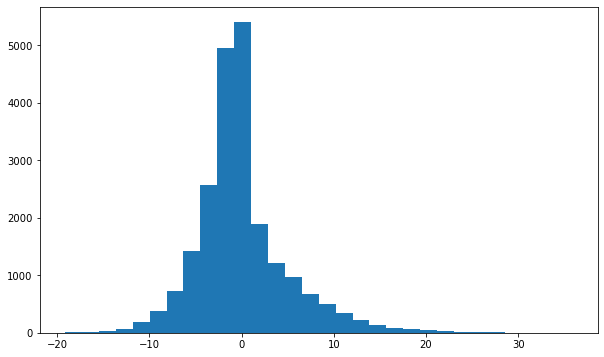

In [852]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(residual, bins=30);